In [81]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

# Load Dataset

In [82]:
dataset=pd.read_csv('spam.csv',encoding="ISO-8859-1")

In [83]:
dataset.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [84]:
dataset.isna().sum()

v1    0
v2    0
dtype: int64

In [85]:
dataset.rename(columns={'v1':'label','v2':'text'},inplace=True)

In [86]:
dataset.columns

Index(['label', 'text'], dtype='object')

<Axes: xlabel='label'>

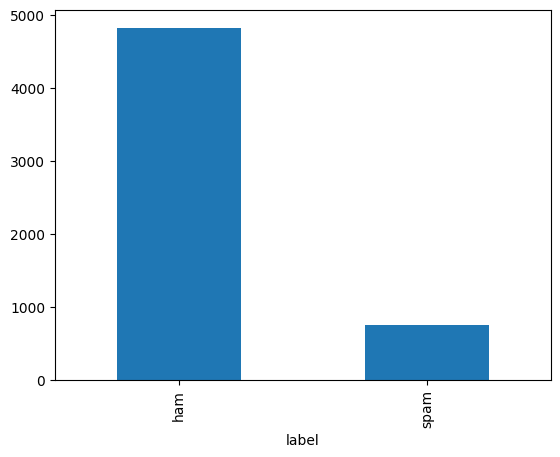

In [87]:
dataset['label'].value_counts().plot(kind='bar')

# Remove special numbers, and extra spaces and "Stopwords".

In [88]:
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
all_stopwords=stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vishn\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [89]:
def convert(text):
    text=text.lower()
    text=re.sub(r'\d+','',text)
    text=re.sub(r'[^a-z\s,\.!?]',' ',text)
    text=re.sub(r'\s+',' ',text)

    words=text.split()
    flatten_words=[]
    for word in words:
        if word not in all_stopwords:
            flatten_words.append(word)
    return ' '.join(word for word in flatten_words)

In [90]:
dataset['text']=dataset['text'].apply(convert)

In [91]:
dataset['text'][9]

'mobile months more? u r entitled update latest colour mobiles camera free! call mobile update co free'

# Apply lemmatization to get the base form of words.

In [92]:
import spacy

In [93]:
nlp=spacy.load('en_core_web_md',disable=['parser','ner'])

In [94]:
def convert_lemmatize(text):
    sentance_word_list=nlp.pipe(text,batch_size=200)
    lemmatize=[]
    for each_sentance_list in sentance_word_list:
        lemmatize_sentance=""
        for word in each_sentance_list:
            if word.is_punct:
                lemmatize_sentance=lemmatize_sentance.rstrip()+word.text+" "
            else:
                lemmatize_sentance+=word.lemma_+" "
        lemmatize.append(lemmatize_sentance)
    return lemmatize

In [95]:
dataset['text']=convert_lemmatize(dataset['text'])

In [96]:
dataset['text'][10]

'go to home soon want talk stuff anymore tonight, k? cry enough today. '

# Tokenization and Embedding

In [97]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [98]:
max_words=5000
tokenize=Tokenizer(num_words=max_words,oov_token="<OOV>")   # Handle out-of-vocabulary words
tokenize.fit_on_texts(dataset['text'])

In [99]:
sequences=tokenize.texts_to_sequences(dataset['text'])

In [100]:
fixed_length=30
padded_sequence=pad_sequences(sequences,maxlen=fixed_length,padding='post',truncating='post')
padded_sequence=np.array(padded_sequence)

In [101]:
print("Sample Tokenized Sequence:", sequences[0])

Sample Tokenized Sequence: [5, 3378, 303, 543, 513, 1065, 47, 71, 250, 879, 92, 2372, 1066, 3, 3379, 78]


In [102]:
print("Sample Padded Sequence:", padded_sequence[1550])

Sample Padded Sequence: [  24   55    3  691   49 1059  946 1782 2850    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


In [103]:
print("Shape of padded sequences:", padded_sequence.shape)

Shape of padded sequences: (5572, 30)


# Splitting dataset

In [104]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
labels=le.fit_transform(dataset['label'])

In [105]:
labels

array([0, 0, 1, ..., 0, 0, 0])

In [106]:
from sklearn.model_selection import train_test_split
x_train,x_valid,y_train,y_valid=train_test_split(padded_sequence,labels,test_size=0.2,random_state=10)

# Deep Learning Model Selection

In [107]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,LSTM,Bidirectional,Dense,Dropout

In [108]:
embedding_dim=128
lstm_units=64
dropout_rate=0.3

In [109]:
model=Sequential([
    Embedding(input_dim=max_words,output_dim=embedding_dim,input_length=fixed_length),
    Bidirectional(LSTM(lstm_units,return_sequences=True)),
    Dropout(dropout_rate),
    LSTM(lstm_units),
    Dropout(dropout_rate),
    Dense(32,activation='relu'),
    Dense(1,activation='sigmoid')
])

C:\Users\vishn\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [110]:
from tensorflow.keras.optimizers import Adam
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.001),metrics=['accuracy'])

In [111]:
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

easrlystopping=EarlyStopping(monitor='val_loss',patience=5,restore_best_weights=True)
reduce_r=ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=4,min_lr=1e-6)

In [112]:
history=model.fit(
    x_train,y_train,
    validation_data=(x_valid,y_valid),
    epochs=20,
    batch_size=32,
    callbacks=[easrlystopping,reduce_r]
)

Epoch 1/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - accuracy: 0.8733 - loss: 0.3387 - val_accuracy: 0.9803 - val_loss: 0.0635 - learning_rate: 0.0010
Epoch 2/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.9865 - loss: 0.0599 - val_accuracy: 0.9839 - val_loss: 0.0692 - learning_rate: 0.0010
Epoch 3/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9938 - loss: 0.0354 - val_accuracy: 0.9874 - val_loss: 0.0492 - learning_rate: 0.0010
Epoch 4/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9958 - loss: 0.0214 - val_accuracy: 0.9677 - val_loss: 0.0843 - learning_rate: 0.0010
Epoch 5/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - accuracy: 0.9957 - loss: 0.0170 - val_accuracy: 0.9892 - val_loss: 0.0572 - learning_rate: 0.0010
Epoch 6/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.9985 - loss: 0.0098 - val_accuracy: 0.9839 - val_loss: 0.0953 - learning_rate: 0.0010
Epoch 7/20
140/140 ━━━━━━━━━━━━━━━━━━━━ 3s 25ms/step - accuracy: 0.9971 - loss: 0.

# Saving a model

In [113]:
model.save('spam_mail_model.h5')

In [114]:
import pickle
with open('stopwords.pkl','wb') as file:
    pickle.dump(all_stopwords,file)

In [115]:
preprocessing={
    'nlp':nlp,
    'tokenizer':tokenize,
    'max_length':fixed_length
}

with open('preprocessing.pkl','wb') as file:
    pickle.dump(preprocessing,file)